In [6]:
import numpy as np 
import matplotlib.pyplot as plt

In [9]:
n_visible =784
n_hidden = 50
hidden_bias = np.random.randn(n_hidden)
visible_bias = np.random.randn(n_visible)
v0_state = np.zeros(n_visible, np.float32)
W = np.zeros((n_visible, n_hidden), np.float32)



In [156]:
#temp
a = np.array([[1, 2, 3], [5, 6, 7], [8, 9, 10]])
b = np.array([[1], [2], [3]])
c = np.dot(a, b)
c = a @ b
print(type(c))
print(c)


<class 'numpy.ndarray'>
[[14]
 [38]
 [56]]


In [157]:
def sigmoid(X):
        return tf.nn.sigmoid(X)
def relu(X):
    return np.maximum(X, 0)

In [158]:
print(v0_state.shape)

(784,)


In [10]:
#computing the hidden nodes probability vector
# h0_prob = sigmoid(([v0_state] @ W) + hidden_bias); 
# print(h0_prob.shape)
# print(type(h0_prob))
# print("first 15 hidden probs: ", h0_prob[0][:15])

v0_state = tf.Variable(tf.zeros([784]), tf.float32)
#return only the generated hidden states
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state
h0_state  = hidden_layer(v0_state, W, hidden_bias)

print(f'first 15 hidden states:{h0_state[:15]}')
print(h0_state.shape)
    

first 15 hidden states:[[0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
  1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0.]]
(1, 50)


2024-02-25 16:21:25.207273: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [11]:
#reconstruction from hidden nodes
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
 
    return v1_state[0]


v1_state = reconstructed_output(h0_state, W, visible_bias)
print("hidden state shape:" ,h0_state.shape)
print("v1 state shape:", v1_state.shape)
print(v1_state[:5])

hidden state shape: (1, 50)
v1 state shape: (784,)
tf.Tensor([1. 1. 0. 1. 1.], shape=(5,), dtype=float32)


<h2>Goal</h2>
 <b>Maximize the liklihood of our data being drawn from that distribution</b>
<h2>Error Calculation</h2>
In each epoch, the "error" is computed as a sum of the squared difference between step 1 and step n, i.e the difference between the original data and it's reconstruction
<br>The Mean Square Error(MSE)


In [13]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0_state - v1_state))
print("error" , err.numpy())

error 0.0


<h2>Training the model</h2>
In order to train the RBM, the goal is to maximize the product of probabilities assigned to all rows <b>v</b> in the training set <b>V</b>(a matrix) 
$$\arg \max_W \prod_{\mathbf{v}\in\mathbf{V}_T} p(\mathbf{v})$$

this is equivalent to maximizing the expectation of the log probability,
$$\arg\max_W\left[ \mathbb{E} \left(\prod_{\mathbf v\in \mathbf V}\text{log} \left(p(\mathbf v)\right) \right) \right]$$


so the approach is to update the weights $W_{ij}$ to increase <b>p(v)</b> for all <b>v</b>, so we need to calculate the derivative
$$\frac{\partial \log p(\mathbf v)}{\partial W_{ij}}$$

This cannot be implemented using the usual gradient descent algorithm, so another approach is used that includes: 
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>

....to be added later


<h3>Class Implementaion</h3>

In [138]:
class RBM:
    def __init__(self, n_visible,n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        

In [72]:
#ignore this, generated by gpt
class BoltzmannMachine:
    def __init__(self, n_visible, n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.weights = np.random.randn(n_visible, n_hidden)
        self.visible_bias = np.random.randn(n_visible)
        self.hidden_bias = np.random.randn(n_hidden)
        return 
    def sigmoid(self, x):
        return np.exp(np.minimum(x, 0)) / (1 + np.exp(-np.abs(x)))

    def gibbs_sampling(self, visible_data, num_iterations = 1000): 
        samples = np.zeros((num_iterations, self.n_visible))
        visible_state = visible_data
        for t in range(num_iterations): 
            hidden_probs = self.sigmoid(np.dot(visible_state, self.weights) + self.hidden_bias)
            hidden_state = np.random.binomial(1, hidden_probs)
            visible_probs = self.sigmoid(np.dot(hidden_state, self.weights.T)  + self.visible_bias)
            visible_state = np.random.binomial(1, visible_probs) 
            samples[t] = visible_state
        return samples 
    def train(self, data, learning_rate=0.1, num_epochs=1000):
        for epoch in range(num_epochs):
            data_batch = data[np.random.randint(data.shape[0])]
            data_batch = data_batch.reshape(1,-1)
            positive_hidden_probs = self.sigmoid(np.dot(data_batch, self.weights) + self.hidden_bias)
            # print(self.weights.shape)
            # print(positive_hidden_probs.shape)
            # print(data_batch.shape)
            positive_hidden_state = np.random.binomial(1, positive_hidden_probs)
            positive_associations = np.dot(data_batch.T, positive_hidden_probs)

            negative_visible_probs = self.sigmoid(np.dot(positive_hidden_state, self.weights.T) + self.visible_bias)
            negative_visible_state = np.random.binomial(1, negative_visible_probs)
            negative_hidden_probs = self.sigmoid(np.dot(negative_visible_state, self.weights) + self.hidden_bias)
            negative_associations = np.dot(negative_visible_state.T, negative_hidden_probs)

            self.weights += learning_rate * (positive_associations - negative_associations)
            self.visible_bias += learning_rate * np.mean(data_batch - negative_visible_state, axis=0)
            self.hidden_bias += learning_rate * np.mean(positive_hidden_state - negative_hidden_probs, axis=0)

        
        

<h2>Normal Implementation</h2>

In [2]:
import tensorflow as tf
from keras.datasets import mnist
from tensorflow.keras.layers import Flatten

In [4]:
(train_X, train_y), (test_X, test_y)= mnist.load_data()
flatten = Flatten(dtype='float32')
train_X = flatten(train_X/ 255.0)
train_y = flatten(train_y/255.0)

<h3>Without tf</h3>

In [141]:
def create_batches(data, label, batch_size):
    num_samples = len(data)
    num_batches = num_samples // batch_size
    if num_samples % batch_size != 0:
        num_batches += 1
    batches = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i+1) * batch_size, num_samples)#last batch ko lagi if num_samples % batch_size != 0 
        batch_data = data[start_index:end_index]
        batch_label = label[start_index:end_index]
        batches.append((batch_data, batch_label))
    return batches

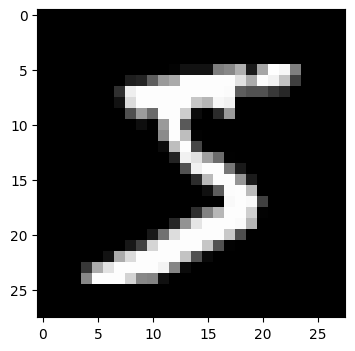

In [146]:
a = train_X[0]
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.imshow(a, cmap = "gray")

In [147]:
print(train_X.shape)

(60000, 28, 28)


In [168]:
train_X_flattened = tf.convert_to_tensor(train_X.reshape(train_X.shape[0], -1),dtype=tf.float32)
print(train_X_flattened.shape)
train_y = train_y / 255.0
print(y.shape)

(60000, 784)
(200, 784)


In [169]:
print(train_X_flattened[:5])


tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(5, 784), dtype=float32)


<h3>/withouttf</h3>

In [16]:
#main training 
alpha = 0.01
epochs = 10
batchsize = 200
weights = []
errors = []
batch_number = 0
K = 1
v0_state = tf.Variable(tf.zeros([784]), tf.float32)
h0_state = tf.Variable(tf.zeros([100]), tf.float32)
hb = tf.Variable(tf.zeros([100]), tf.float32)
vb = tf.Variable(tf.zeros([784]), tf.float32)
W = tf.Variable(tf.zeros([784, 100]), tf.float32)

#creating batches 
# train_ds = create_batches(train_X_flattened, train_y, batchsize)
train_ds = \
    tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(batchsize)

In [17]:
h1_prob = tf.nn.sigmoid(tf.matmul([v1_state], W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random.uniform(tf.shape(h1_prob)))) #s

In [18]:
print("error: ", error(v0_state, v1_state))

error:  tf.Tensor(0.095663264, shape=(), dtype=float32)


In [19]:
for epoch in range(epochs):
    for batch_x, batch_y in train_ds:
        batch_number += 1
        for i_sample in range(batchsize):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == batchsize-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % epoch, 
                       "batch #: %i " % batch_number, "of %i" % int(60e3/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)


Epoch: 0 batch #: 1  of 300 sample #: 199 reconstruction error: 0.160882
Epoch: 0 batch #: 2  of 300 sample #: 199 reconstruction error: 0.174637
Epoch: 0 batch #: 3  of 300 sample #: 199 reconstruction error: 0.103273
Epoch: 0 batch #: 4  of 300 sample #: 199 reconstruction error: 0.103933
Epoch: 0 batch #: 5  of 300 sample #: 199 reconstruction error: 0.095666
Epoch: 0 batch #: 6  of 300 sample #: 199 reconstruction error: 0.159343
Epoch: 0 batch #: 7  of 300 sample #: 199 reconstruction error: 0.066670
Epoch: 0 batch #: 8  of 300 sample #: 199 reconstruction error: 0.099906
Epoch: 0 batch #: 9  of 300 sample #: 199 reconstruction error: 0.083115
Epoch: 0 batch #: 10  of 300 sample #: 199 reconstruction error: 0.158129
Epoch: 0 batch #: 11  of 300 sample #: 199 reconstruction error: 0.098639
Epoch: 0 batch #: 12  of 300 sample #: 199 reconstruction error: 0.124556
Epoch: 0 batch #: 13  of 300 sample #: 199 reconstruction error: 0.045676
Epoch: 0 batch #: 14  of 300 sample #: 199 reco

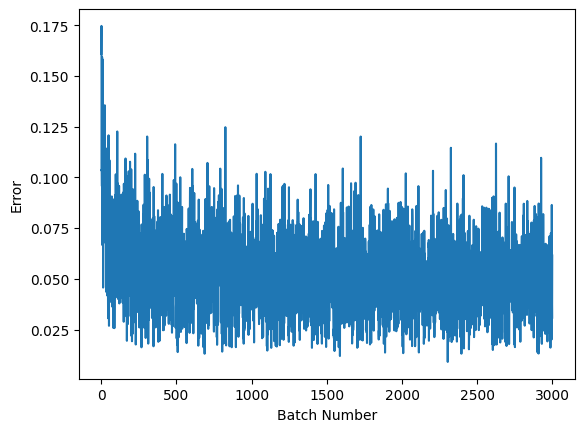

In [20]:
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

In [21]:
print(W) # a weight matrix of shape (50,784)
print(W.shape)

tf.Tensor(
[[-0.4899998  -0.30999997 -0.20000002 ... -0.14999999 -0.33999994
  -0.29999998]
 [-0.43999985 -0.30999997 -0.24000004 ... -0.14999999 -0.31999996
  -0.31999996]
 [-0.46999982 -0.27       -0.21000002 ... -0.07999999 -0.27
  -0.25000003]
 ...
 [-0.43999985 -0.30999997 -0.29       ... -0.10999998 -0.3799999
  -0.43999985]
 [-0.45999983 -0.3799999  -0.21000002 ... -0.13999999 -0.29999998
  -0.32999995]
 [-0.5399998  -0.3999999  -0.24000004 ... -0.11999998 -0.27
  -0.29      ]], shape=(784, 100), dtype=float32)
(784, 100)


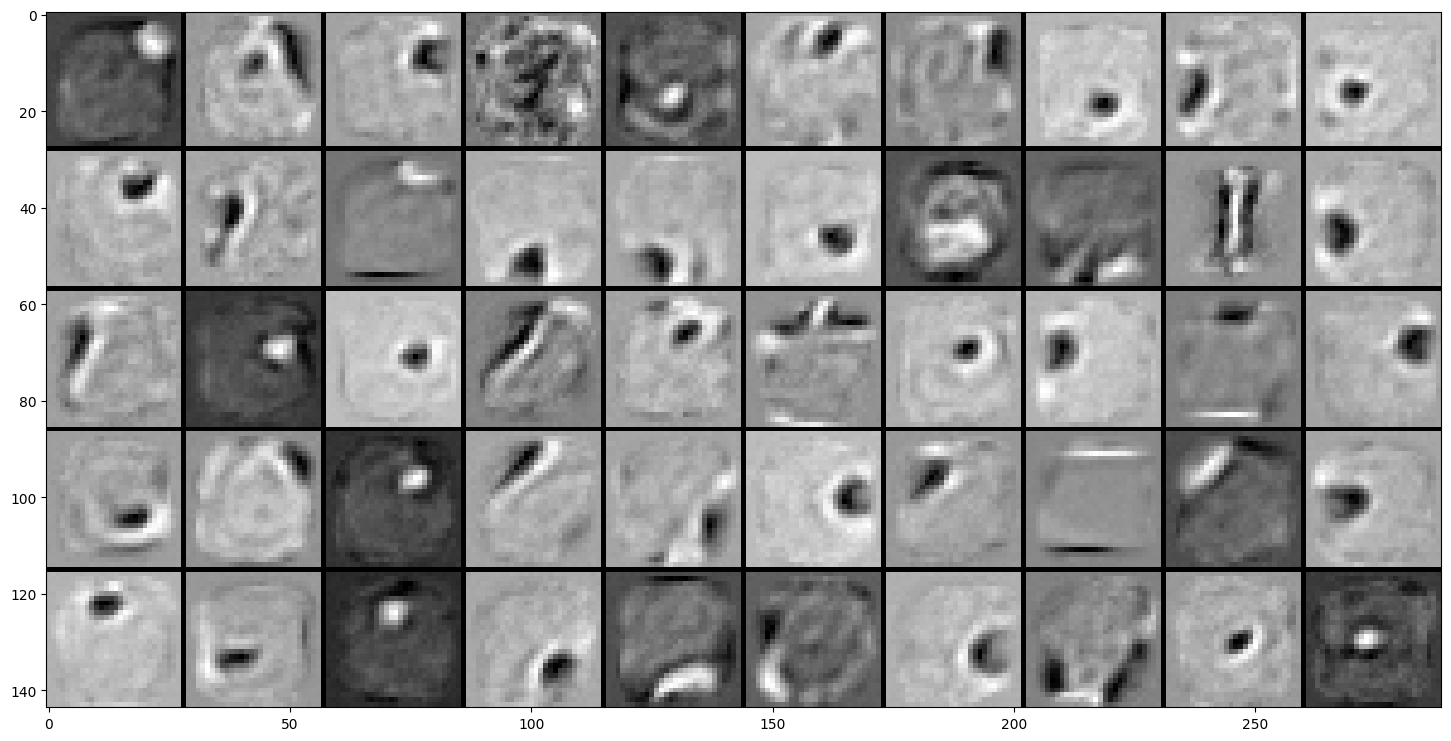

In [24]:
from utils import tile_raster_images
tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))

from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=W.numpy().T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  


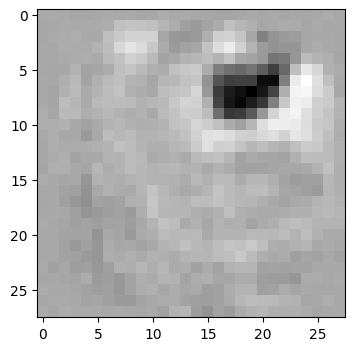

In [25]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X =W.numpy().T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

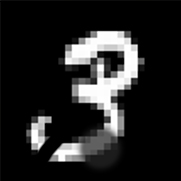

In [26]:
img = Image.open('destructed3.jpg')
img

In [27]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

sample_case = tf.cast(sample_case, dtype=tf.float32)

In [28]:
hh0_p = tf.nn.sigmoid(tf.matmul(sample_case, W) + hb)
hh0_s = tf.round(hh0_p)

print("Probability nodes in hidden layer:" ,hh0_p)
print("activated nodes in hidden layer:" ,hh0_s)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s, tf.transpose(W)) + vb)

print(vv1_p)

Probability nodes in hidden layer: tf.Tensor(
[[8.3476311e-01 1.2339611e-04 1.3675225e-13 1.8191004e-04 3.9953772e-02
  9.6043630e-17 9.5229261e-02 5.0323035e-10 1.9372306e-04 9.9434000e-01
  4.7956378e-12 2.1076110e-05 9.9975795e-01 3.4904463e-13 2.8602227e-15
  3.4103298e-14 1.0000000e+00 7.9927479e-05 7.8681400e-20 9.6145383e-04
  3.1364497e-03 1.0000000e+00 1.6859665e-11 6.2023242e-12 1.7675238e-04
  7.5333129e-11 2.6536149e-09 9.9978262e-01 8.4925972e-07 3.3044869e-09
  6.8957312e-11 9.9928683e-01 9.9999976e-01 1.5918640e-04 9.9931145e-01
  3.0472750e-02 8.3711603e-07 3.0788208e-10 6.3094208e-03 5.0866860e-03
  1.3256839e-16 9.9991024e-01 1.0000000e+00 1.1728061e-07 9.9999583e-01
  9.9999964e-01 2.7174520e-01 7.5559723e-07 2.6578770e-11 9.9997318e-01
  9.9436909e-01 9.4933772e-01 9.9997902e-01 9.9916232e-01 3.6519579e-11
  9.4109124e-01 3.4918243e-01 5.1920012e-02 7.5421297e-10 1.6421035e-04
  9.9457294e-01 9.9994659e-01 8.4572960e-10 4.2492498e-02 1.6739785e-08
  2.9020772e-05 5.

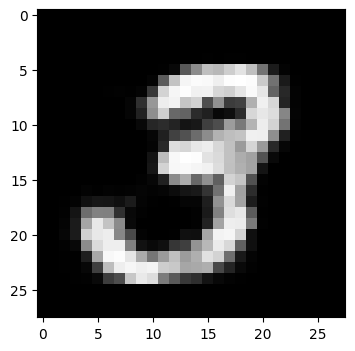

In [29]:
img = Image.fromarray(tile_raster_images(X=vv1_p.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 